# **High-Frequency Trading Simulator — Hands-on Tutorial**

This notebook walks through the core building blocks of the High-Frequency Trading Simulator project. We will explore how Hawkes processes drive clustered order flow, how to inspect and visualise simulated event streams, and how to feed them into the deterministic limit order book used by the Python backtester.

## What we'll cover
- Repository tour: how the pieces fit together
- Hawkes process simulation from Python
- Visual diagnostics and persistence helpers
- Synthetic order flow replay inside the limit order book
- Where to go next for calibration, backtesting, and dashboards

## Prerequisites
- Clone/build instructions are in `README.md`; the native bridges are optional for the tutorial because pure-Python fallbacks are bundled.
- Recommended Python version: 3.10+ with `numpy` and `matplotlib` available.
- For reproducible plots in restricted environments, we direct Matplotlib to a writable cache directory.

In [46]:
import os
import sys
import pathlib

repo_root = pathlib.Path.cwd()
if not (repo_root / 'python').exists():
    for candidate in [repo_root] + list(repo_root.parents):
        if (candidate / 'python').exists():
            repo_root = candidate
            break
    else:
        raise RuntimeError('Could not locate repository root containing the python package')

python_dir = repo_root / 'python'
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
if str(python_dir) not in sys.path:
    sys.path.insert(0, str(python_dir))

mpl_dir = repo_root / '.matplotlib'
mpl_dir.mkdir(exist_ok=True)
os.environ.setdefault('MPLCONFIGDIR', str(mpl_dir))

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (9, 4)
plt.rcParams['axes.grid'] = True

print(f'Repo root: {repo_root}')
print(f"Using MPLCONFIGDIR={os.environ['MPLCONFIGDIR']}")

Repo root: /Users/sohaib/Downloads/untitled folder/High-frequency-trading-simulator-main
Using MPLCONFIGDIR=/Users/sohaib/Downloads/untitled folder/High-frequency-trading-simulator-main/.matplotlib


## Repository tour
Below is a short summary of the directories you'll meet most often:
- `src/`: Modern C++17 limit order book, Hawkes intensity kernels, and CLI demos.
- `python/`: Analytics toolkit (simulation, visualisation, backtester bridge, Streamlit app).
- `data/`: Sample event streams and outputs from the bundled demos.
- `configs/` & `experiments/`: JSON configurations and experiment runners for research benchmarks.
- `scripts/`: One-off utilities including Hawkes calibration workflows.
- `tests/`: Catch2 and pytest suites that keep both the C++ and Python layers deterministic.

## Simulating clustered order flow with Hawkes processes
We'll start with the exponential kernel implementation that mirrors the one used in the C++ core. The Python wrapper automatically loads the native `hawkes_bridge` shared library when available and otherwise falls back to the pure-Python thinning sampler.

In [47]:
from typing import Callable

from python import (
    ExpKernel,
    PowerLawKernel,
    simulate_thinning_exp_fast,
    simulate_thinning_general,
)
import python.viz as viz
from python.io_utils import save_csv, save_json

In [48]:
T = 200.0
mu_exp = 0.25
exp_kernel = ExpKernel(alpha=0.9, beta=1.4)

def lognormal_mark(rng: np.random.Generator) -> float:
    return float(np.exp(rng.normal(0.0, 0.45)))

EV = float(np.exp(0.45 ** 2 / 2))
branching_exp = exp_kernel.branching_ratio(EV)
print(f"Branching ratio n = {branching_exp:.3f} (keep n < 1 for stability)")

exp_times, exp_marks = simulate_thinning_exp_fast(
    mu_exp,
    exp_kernel,
    lognormal_mark,
    T=T,
    seed=42,
)
print(f"Generated {len(exp_times)} events. Mean mark={float(np.mean(exp_marks)):.3f}")

Branching ratio n = 0.711 (keep n < 1 for stability)
Generated 191 events. Mean mark=1.073


In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120  # optional, just for crisper plots


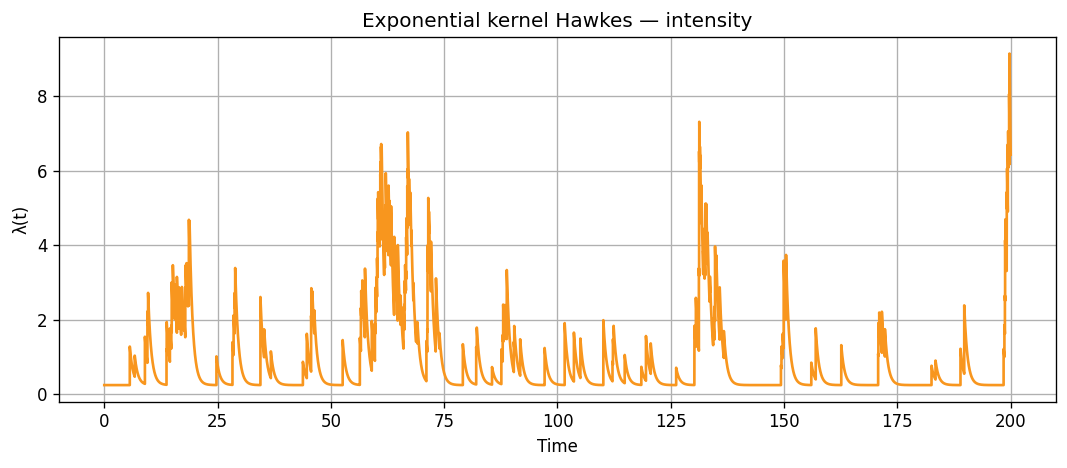

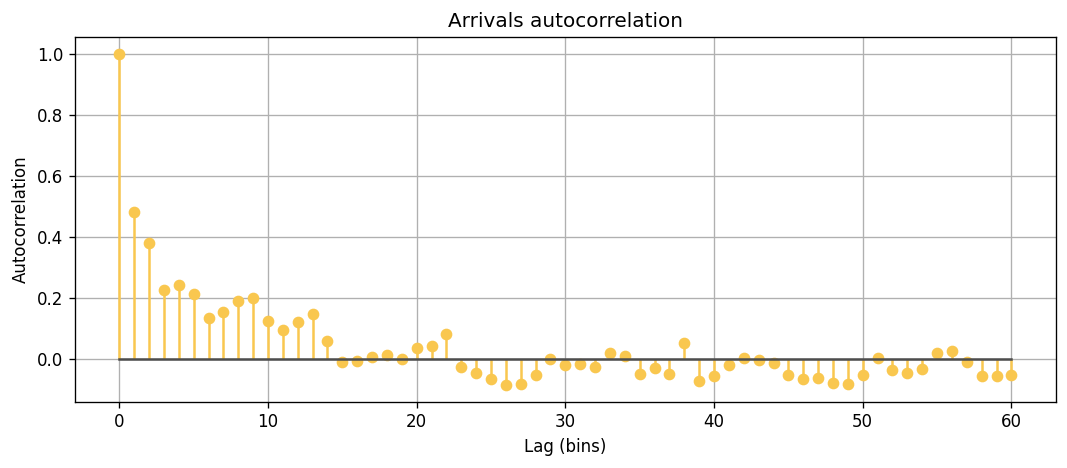

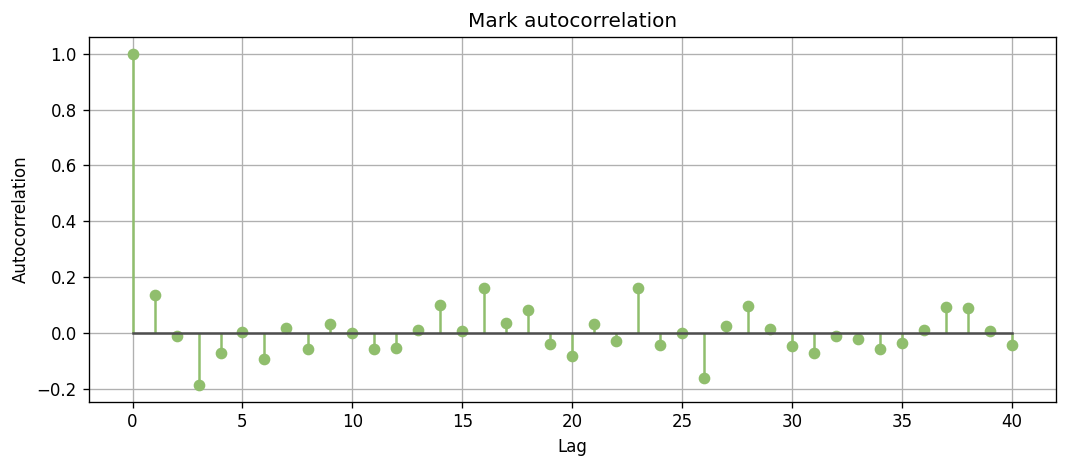

In [50]:
grid = np.linspace(0.0, T, 40000000)
exp_intensity = viz.intensity_on_grid(mu_exp, exp_kernel, exp_times, exp_marks, grid)

viz.plot_intensity(grid, exp_intensity, title="Exponential kernel Hawkes — intensity")
viz.plot_counts_acf(exp_times, T, bin_w=0.5, max_lag=60, title="Arrivals autocorrelation")
viz.plot_mark_acf(exp_marks, max_lag=40, title="Mark autocorrelation")

plt.show()

### Power-law kernel variant
The heavy-tailed kernel captures longer memory. We'll reuse the same workflow to see how the intensity differs.

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120 


Branching ratio n = 0.754 (γ must exceed 1)
Generated 0 events. Mean mark=nan


/opt/homebrew/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


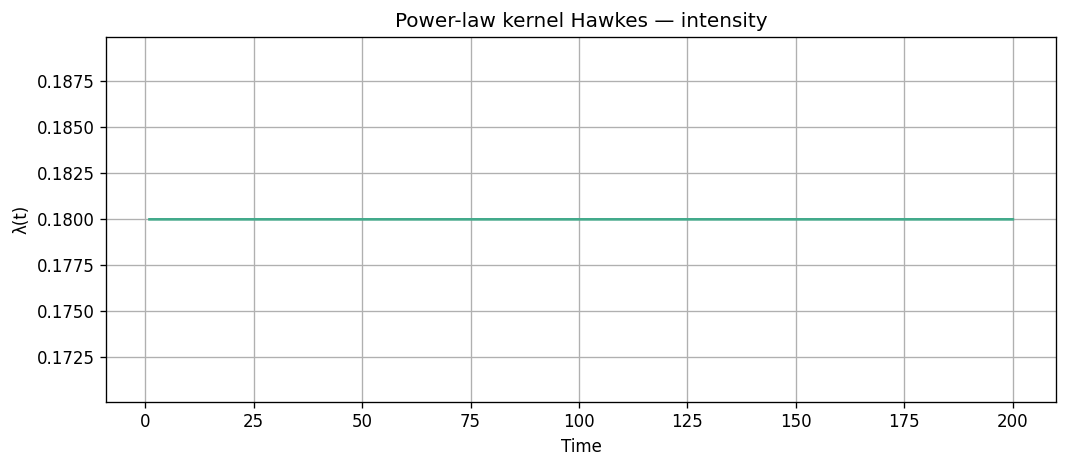

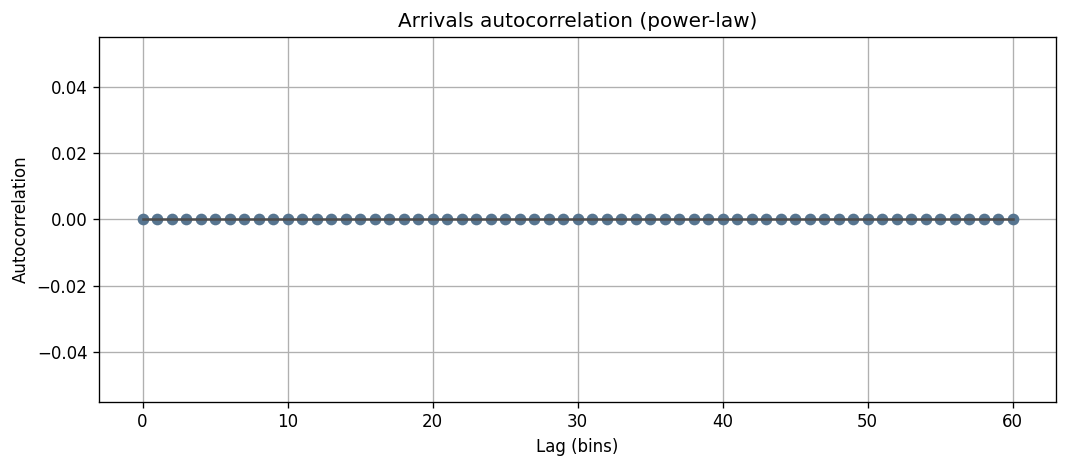

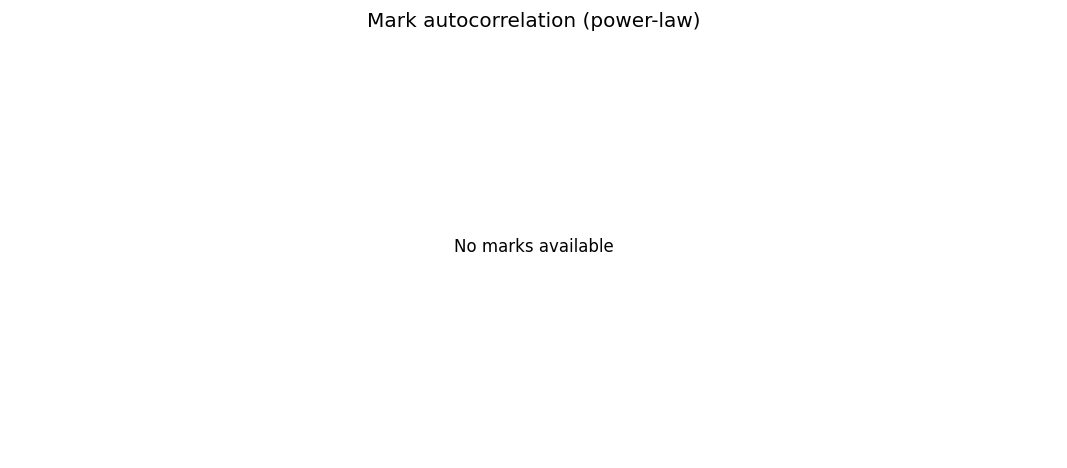

In [52]:
from python.kernels import PowerLawKernel

T_power = 200.0
mu_power = 0.18
power_kernel = PowerLawKernel(alpha=0.12, c=0.1, gamma=1.4)

def exponential_mark(rng: np.random.Generator) -> float:
    return float(rng.exponential(1.0))

branching_power = power_kernel.branching_ratio(1.0)
print(f"Branching ratio n = {branching_power:.3f} (γ must exceed 1)")

power_times, power_marks = simulate_thinning_general(
    mu_power,
    power_kernel,
    exponential_mark,
    T=T_power,
    seed=43,
)
print(f"Generated {len(power_times)} events. Mean mark={float(np.mean(power_marks)):.3f}")

power_grid = np.linspace(1, T_power, 4000)
power_intensity = viz.intensity_on_grid(
    mu_power, power_kernel, power_times, power_marks, power_grid
)

viz.plot_intensity(
    power_grid,
    power_intensity,
    title="Power-law kernel Hawkes — intensity",
)
viz.plot_counts_acf(
    power_times,
    T_power,
    bin_w=0.5,
    max_lag=60,
    title="Arrivals autocorrelation (power-law)",
)
viz.plot_mark_acf(
    power_marks,
    max_lag=40,
    title="Mark autocorrelation (power-law)",
)

plt.show()

### Comparing intensity profiles
We can overlay both kernels to highlight how the rougher power-law kernel sustains elevated activity for longer.

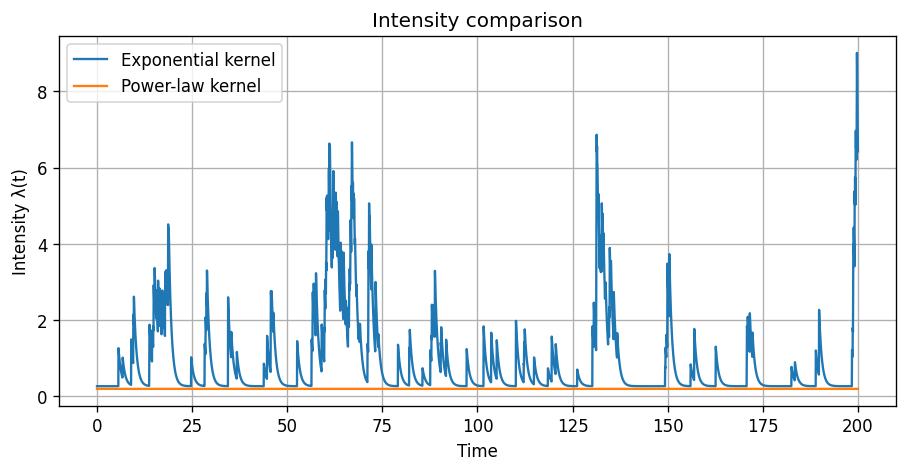

In [53]:
common_grid = np.linspace(0.0, max(T, T_power), 4000)
exp_interp = viz.intensity_on_grid(mu_exp, exp_kernel, exp_times, exp_marks, common_grid)
power_interp = viz.intensity_on_grid(
    mu_power, power_kernel, power_times, power_marks, common_grid
)

fig, ax = plt.subplots()
ax.plot(common_grid, exp_interp, label="Exponential kernel", linewidth=1.4)
ax.plot(common_grid, power_interp, label="Power-law kernel", linewidth=1.4)
ax.set_xlabel("Time")
ax.set_ylabel("Intensity λ(t)")
ax.legend()
ax.set_title("Intensity comparison")
plt.show()

### Inspecting the simulated events
For quick inspection we can turn the arrays into a tabular view. The helper below uses pandas when it's installed and otherwise shows a short snippet.

In [54]:
try:
    import pandas as pd
    from IPython.display import display

    exp_df = pd.DataFrame({"time": exp_times, "mark": exp_marks})
    power_df = pd.DataFrame({"time": power_times, "mark": power_marks})
    display(exp_df.head())
    display(power_df.head())
except ImportError:
    print("Install pandas to get a DataFrame view. First five exponential events:")
    for t, v in list(zip(exp_times, exp_marks))[:5]:
        print(f"t={t:.4f}, mark={v:.3f}")

,time,mark
0,5.628528,1.146969
1,6.716373,0.626258
2,8.965100,1.401724
3,9.518128,1.526922
4,9.662190,0.415628


,time,mark


### Persisting simulations for later analysis
The `python/io_utils.py` helpers mirror the CLI demos and write CSV/JSON artefacts under `data/runs/`.

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120  # optional, just for crisper plots

In [56]:
output_dir = repo_root / "data" / "runs"
output_dir.mkdir(parents=True, exist_ok=True)

save_csv(output_dir / "tutorial_exp_events.csv", exp_times, exp_marks)
save_json(
    output_dir / "tutorial_exp_events.json",
    {
        "kernel": "exponential",
        "mu": mu_exp,
        "params": {"alpha": exp_kernel.alpha, "beta": exp_kernel.beta},
        "branching_ratio": float(branching_exp),
    },
    exp_times,
    exp_marks,
)
print(f"Wrote CSV/JSON under {output_dir}")

Wrote CSV/JSON under /Users/sohaib/Downloads/untitled folder/High-frequency-trading-simulator-main/data/runs


## Feeding events into the deterministic order book
The Python backtester wraps the C++ limit order book. When the native bridge is missing, `PythonOrderBook` offers an instructive pure-Python implementation with the same API.

In [57]:
import itertools
from dataclasses import asdict

from python.backtester.synthetic import (
    PoissonOrderFlowConfig,
    PoissonOrderFlowGenerator,
    SequenceValidator,
)
from python.backtester.order_book import PythonOrderBook

In [58]:
validator = SequenceValidator()
flow_config = PoissonOrderFlowConfig(
    symbol="SYN",
    message_count=200,
    base_rate_hz=5_000.0,
    tick_size=0.01,
    price_levels=20,
    seed=11,
)
generator = PoissonOrderFlowGenerator(flow_config)
events = list(itertools.islice(generator.stream(validator=validator), 50))
report = validator.report()
print(f"Generated {len(events)} events. Sequence OK? {report.ok}")
print(
    f"Orphan cancels: {report.orphan_cancels} | Orphan executes: {report.orphan_executes}"
)

Generated 50 events. Sequence OK? True
Orphan cancels: 0 | Orphan executes: 0


In [59]:
book = PythonOrderBook(depth=5)
snapshots = []
fills = []

for event in events:
    update = book.apply_event(event)
    if update.snapshot is not None:
        snapshots.append(update.snapshot)
    if update.fills:
        fills.extend(update.fills)

latest_snapshot = snapshots[-1]
print(
    "Best bid: "
    f"{latest_snapshot.best_bid} x {latest_snapshot.bid_size} | "
    f"Best ask: {latest_snapshot.best_ask} x {latest_snapshot.ask_size}"
)

Best bid: 100.19 x 8.559407925919384 | Best ask: 99.84 x 21.841980848489268


In [60]:
depth_view = latest_snapshot.depth[:5]
try:
    import pandas as pd
    from IPython.display import display

    display(pd.DataFrame(depth_view))
except ImportError:
    print("Top 5 levels:")
    for level in depth_view:
        print(level)

,side,price,size
0,BUY,100.19,8.559408
1,BUY,100.16,3.825580
2,BUY,100.14,12.063174
3,BUY,100.02,17.673765
4,BUY,99.96,8.224292


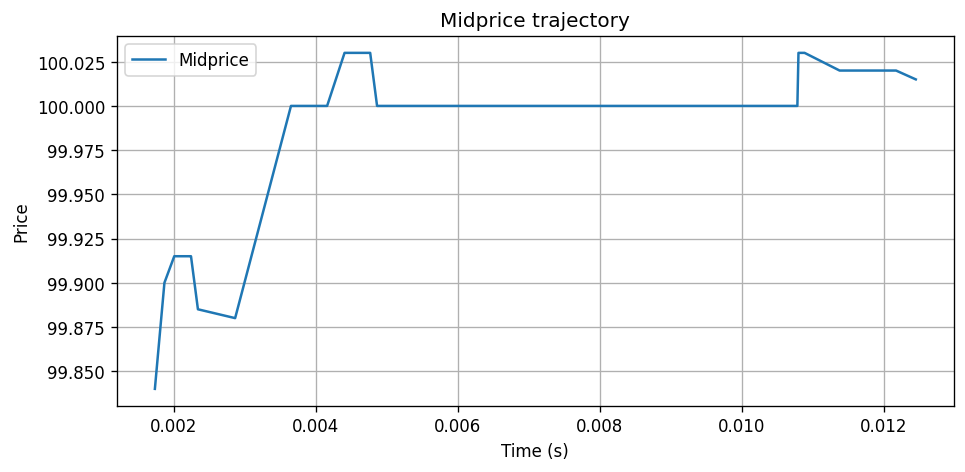

In [61]:
mid_t = []
mid_v = []
for snap in snapshots:
    mid = snap.midprice
    if mid is None:
        continue
    mid_t.append(snap.timestamp_ns * 1e-9)
    mid_v.append(mid)

fig, ax = plt.subplots()
ax.plot(mid_t, mid_v, label="Midprice")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Price")
ax.legend()
ax.set_title("Midprice trajectory")
plt.show()

## Where to go next
- To calibrate Hawkes intensities on recorded data, study `scripts/hawkes_calibration_analysis.py` and the `hawkes_baseline.ipynb` notebook.
- The C++ CLIs in `src/hawkes_mle_cli.cpp` and `src/order_flow` mirror the Python APIs for full-performance workloads.
- Launch the Streamlit dashboards with `python/streamlit_app.py` or `python/streamlit_app_backtest.py` after activating a virtual environment.
- Reproducible experiment grids live in `experiments/run_matrix.py`; summarise results with the helper scripts in `scripts/`.